# Outline

- Installation
- Import
- Dataset
- Training
- Post Processing
- Submission

Break down the results of your classifier.
 - Which category is the easiest to classify? And the hardest? Did this correlate with the distribution of training data? 
 - Visualize five examples where classification went well, and five where classification failed, consider what went wrong in case of the latter. 

Write a short tech report that gives a deeper explanation of your experiments and the rationales. 
 - Hyper-parameters
 - Batch sizes
 - Number of network layers 
 - Adding/removing batch normalization 
 - Increasing/decreasing dropout (if applicable) 
 - Data augmentation techniques (random cropping, normalization, random erasing, etc.) 


# Installation

In [1]:
#!pip install torch
#!pip install torchvision
#!pip install tqdm
#!pip install matplotlib
#!pip install numpy
#!pip install cv2
#!pip install pandas

!pip install draugr -U
!pip install neodroidvision -U

     |████████████████████████████████| 215kB 2.8MB/s 
     |████████████████████████████████| 92kB 31.5MB/s 
     |████████████████████████████████| 174kB 38.8MB/s 
  Created wheel for sorcery: filename=sorcery-0.2.0-cp36-none-any.whl size=10786 sha256=1b6a1762e3a1bdffd6e90a3e5644c1236f3aa5f55633ac3c976725d0481a2d85
  Stored in directory: /tmp/.cache/pip/wheels/98/e3/23/a953057998b64f35e03e14a8f87eabd64843c7c7e258ca5ece
  Created wheel for snoop: filename=snoop-0.2.2-cp36-none-any.whl size=26866 sha256=96f390eb3a2c0ed1cb73441b93c5809c44c46c6c9a7d86ddb3b3e23fc7f66d37
  Stored in directory: /tmp/.cache/pip/wheels/8f/52/60/fcc39e424de6163409ad6aea3c9aa7ac80ec83d533b52acf21
  Created wheel for executing: filename=executing-0.3.3-cp36-none-any.whl size=7440 sha256=cab5dd93825f0e460a743443d68113113770d1e6029981109f2af113b9350897
  Stored in directory: /tmp/.cache/pip/wheels/a7/83/90/8fba6d051659340a2d71b460d28dd841b422c1435f2ff49eda
  Created wheel for littleutils: filename=littleutils-0.2.

# Imports

In [2]:
from tqdm import tqdm
from matplotlib import pyplot
import pandas
import seaborn
import torch
import numpy
from pathlib import Path

from neodroidvision import PROJECT_APP_PATH
from neodroidvision.multitask.fission_net.skip_hourglass import SkipHourglassFissionNet
from neodroidvision.segmentation import BCEDiceLoss, bool_dice, draw_convex_hull
from neodroidvision.segmentation import mask_to_run_length

import draugr
from draugr.torch_utilities import torch_seed, global_torch_device, float_chw_to_hwc_uint, chw_to_hwc, resize_image_cv

import albumentations
import cv2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader


# Hyperparameters

In [3]:
pyplot.style.use('bmh')

base_data_path = Path.cwd().parent / 'input'
base_dataset_path = base_data_path / 'understanding_cloud_organization'
image_path = base_data_path / 'understanding-clouds-resized'

save_model_path = PROJECT_APP_PATH.user_data / 'cloud_seg.model'

SEED = 87539842
batch_size = 8
num_workers = 2
torch_seed(SEED)
criterion = BCEDiceLoss(eps=1.0)
lr = 3e-3
encoding_depth=5
n_epochs=30
working_mask_size = (640, 320) # divisible by 32, scales better with Unet architectures
final_mask_size=(525,350)
final_mask_size_T=final_mask_size[::-1]
MIN_SIZES=[0, 100, 1200, 5000, 10000, 30000]
threshold_samples=20

# Dataset

(3, 320, 640)
(4, 320, 640)
(320, 640, 3)
(320, 640, 4)
(320, 640, 3)
(320, 640, 4)


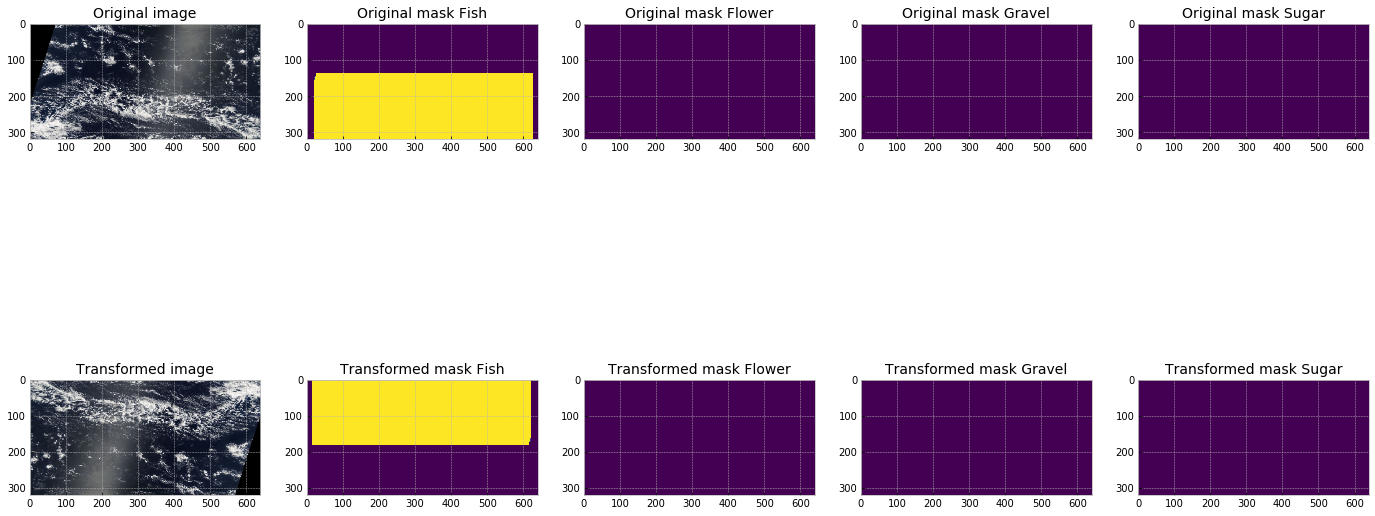

In [4]:
class CloudSegmentationDataset(Dataset):
  categories = {0:"Fish", 1:"Flower", 2:"Gravel", 3:"Sugar"}
  image_size = working_mask_size
  image_size_T = image_size[::-1]

  predictor_channels = 3
  response_channels = len(categories)

  predictors_shape = (*image_size_T, predictor_channels)
  response_shape = (*image_size_T, response_channels)

  predictors_shape_T = predictors_shape[::-1]
  response_shape_T = response_shape[::-1]

  mean = (0.2606705, 0.27866408, 0.32657165)  # Computed prior
  std = (0.25366131, 0.24921637, 0.23504028)  # Computed prior

  def training_augmentations(self):
    return [albumentations.VerticalFlip(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5,
                                            rotate_limit=0,
                                            border_mode=0
                                            ),
            ]

  def validation_augmentations(self):
    """Add paddings to make image shape divisible by 32"""
    return [
      albumentations.Resize(*self.image_size_T),
      # albumentations.Normalize(mean=self.mean, std=self.std)
      # Standardization
      ]

  '''
  def un_standardise(self, img):
    """Add paddings to make image shape divisible by 32"""
    return (img * self.std + self.mean).astype(numpy.uint8)
  '''

  def __init__(self,
               csv_path: Path,
               image_data_path: Path,
               subset: str = "train",
               transp=True,
               N_FOLDS=10,
               SEED=246232,
               ):

    self.transp = transp

    if subset != 'test':
      data_frame = pandas.read_csv(csv_path / f'train.csv')
    else:
      data_frame = pandas.read_csv(csv_path / f'sample_submission.csv')

    data_frame["label"] = data_frame["Image_Label"].apply(lambda x:x.split("_")[1])
    data_frame["im_id"] = data_frame["Image_Label"].apply(lambda x:x.split("_")[0])
    self.data_frame = data_frame
    self.subset = subset
    self.base_image_data = image_data_path

    if subset != 'test':
      id_mask_count = (data_frame.loc[data_frame["EncodedPixels"].isnull() == False, "Image_Label"]
                       .apply(lambda x:x.split("_")[0])
                       .value_counts()
                       .sort_index()
                       .reset_index()
                       .rename(columns={"index":"img_id", "Image_Label":"count"})
                       )  # split data into train and val

      ids = id_mask_count["img_id"].values
      li = [[train_index, test_index]
            for train_index, test_index
            in StratifiedKFold(n_splits=N_FOLDS,
                               random_state=SEED
                               ).split(ids, id_mask_count["count"])
            ]

      self.image_data_path = image_data_path / 'train_images_525'/'train_images_525'

      if subset == 'valid':
        self.img_ids = ids[li[0][1]]
      else:
        self.img_ids = ids[li[0][0]]
    else:
      self.img_ids = data_frame["Image_Label"].apply(lambda x:x.split("_")[0]).drop_duplicates().values
      self.image_data_path = image_data_path / 'test_images_525'/ 'test_images_525'

    if subset == 'train':
      self.transforms = albumentations.Compose(self.training_augmentations() +                         self.validation_augmentations()
                       )
    else:
      self.transforms = albumentations.Compose(self.validation_augmentations())

  def fetch_masks(self,
                  image_name: str):
    """
    Create mask based on df, image name and shape.
    """
    masks = numpy.zeros(self.response_shape, dtype=numpy.float32)
    df = self.data_frame[self.data_frame["im_id"] == image_name]

    for idx, im_name in enumerate(df["im_id"].values):
      for classidx, classid in enumerate(self.categories.values()):
        mpath = str(self.base_image_data / 'train_masks_525' / 'train_masks_525' / f'{classid}{im_name}')
        mask = cv2.imread(mpath,
                          cv2.IMREAD_GRAYSCALE)
        if mask is None:
          continue
        mask = resize_image_cv(mask, self.image_size_T)
        masks[:, :, classidx] = mask

    masks = masks / 255.0
    return masks

  @staticmethod
  def no_info_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = numpy.array([0, 0, 0], numpy.uint8)
    upper = numpy.array([180, 255, 10], numpy.uint8)
    return (~ (cv2.inRange(hsv, lower, upper) > 250)).astype(numpy.uint8)

  def __getitem__(self, idx):
    image_name = self.img_ids[idx]
    img = cv2.imread(str(self.image_data_path / image_name))
    img = resize_image_cv(img, self.image_size_T)
    img_o = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if self.subset == 'test':
      img_o = draugr.uint_hwc_to_chw_float(img_o)
      return img_o, self.no_info_mask(img)

    masks = self.fetch_masks(image_name)
    if self.transforms:
      augmented = self.transforms(image=img_o, mask=masks)
      img_o = augmented["image"]
      masks = augmented["mask"]
    img_o = draugr.uint_hwc_to_chw_float(img_o)
    masks = draugr.hwc_to_chw(masks)
    return img_o, masks

  def __len__(self):
    return len(self.img_ids)

  @staticmethod
  def visualise(image,
                mask,
                original_image=None,
                original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14

    if original_image is None and original_mask is None:
      f, ax = pyplot.subplots(1, 5, figsize=(24, 24))

      ax[0].imshow(image)
      for i in range(4):
        ax[i + 1].imshow(mask[:, :, i])
        ax[i + 1].set_title(f"Mask {CloudSegmentationDataset.categories[i]}",
                            fontsize=fontsize)
    else:
      f, ax = pyplot.subplots(2, 5, figsize=(24, 12))

      ax[0, 0].imshow(original_image)
      ax[0, 0].set_title("Original image",
                         fontsize=fontsize)

      for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i], vmin=0, vmax=1)
        ax[0, i + 1].set_title(f"Original mask {CloudSegmentationDataset.categories[i]}",
                               fontsize=fontsize)

      ax[1, 0].imshow(image)
      ax[1, 0].set_title("Transformed image",
                         fontsize=fontsize)

      for i in range(4):
        ax[1, i + 1].imshow(mask[:, :, i], vmin=0, vmax=1)
        ax[1, i + 1].set_title(f"Transformed mask {CloudSegmentationDataset.categories[i]}",
                               fontsize=fontsize)

    pyplot.show()

  @staticmethod
  def visualise_prediction(
    processed_image,
    processed_mask,
    original_image=None,
    original_mask=None,
    raw_image=None,
    raw_mask=None
    ):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14

    f, ax = pyplot.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title("Original image",
                       fontsize=fontsize)

    for i in range(4):
      ax[0, i + 1].imshow(original_mask[:, :, i], vmin=0, vmax=1)
      ax[0, i + 1].set_title(f"Original mask {CloudSegmentationDataset.categories[i]}",
                             fontsize=fontsize)

    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title("Raw image", fontsize=fontsize)

    for i in range(4):
      ax[1, i + 1].imshow(raw_mask[:, :, i], vmin=0, vmax=1)
      ax[1, i + 1].set_title(f"Predicted mask {CloudSegmentationDataset.categories[i]}",
                             fontsize=fontsize)

    ax[2, 0].imshow(processed_image)
    ax[2, 0].set_title("Transformed image",
                       fontsize=fontsize)

    for i in range(4):
      ax[2, i + 1].imshow(processed_mask[:, :, i])
      ax[2, i + 1].set_title(f"Predicted mask with processing {CloudSegmentationDataset.categories[i]}",
                             fontsize=fontsize
                             )

    pyplot.show()

  def plot_training_sample(self):
    """
    Wrapper for `visualize` function.
    """
    orig_transforms = self.transforms
    self.transforms = None
    image, mask = self.__getitem__(numpy.random.randint(0, self.__len__()))
    print(image.shape)
    print(mask.shape)
    self.transforms = orig_transforms
    image = draugr.float_chw_to_hwc_uint(image)
    mask = draugr.chw_to_hwc(mask)
    print(image.shape)
    print(mask.shape)
    augmented = orig_transforms(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]
    print(augmented_image.shape)
    print(augmented_mask.shape)
    self.visualise(augmented_image,
                   augmented_mask,
                   original_image=image,
                   original_mask=mask)

if True:
    ds = CloudSegmentationDataset(base_dataset_path, image_path)
    ds.plot_training_sample()

# Training

In [5]:
def train_model(model,
                train_loader,
                valid_loader,
                criterion,
                optimizer,
                scheduler,
                save_model_path: Path):
  valid_loss_min = numpy.Inf  # track change in validation loss
  E = tqdm(range(1, n_epochs + 1))
  for epoch in E:
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0

    model.train()
    train_set = tqdm(train_loader, postfix={"train_loss":0.0})
    for data, target in train_set:
      data, target = data.to(global_torch_device(),dtype=torch.float), target.to(global_torch_device(),dtype=torch.float)
      optimizer.zero_grad()
      output, *_ = model(data)
      output = torch.sigmoid(output)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * data.size(0)
      train_set.set_postfix(ordered_dict={"train_loss":loss.item()})

    model.eval()
    with torch.no_grad():
      validation_set = tqdm(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0})
      for data, target in validation_set:
        data, target = data.to(global_torch_device(),dtype=torch.float), target.to(global_torch_device(),dtype=torch.float)

        output, *_ = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
        output = torch.sigmoid(output)

        loss = criterion(output, target)  # calculate the batch loss

        valid_loss += loss.item() * data.size(0)  # update average validation loss
        dice_cof = bool_dice(output.cpu().detach().numpy(), target.cpu().detach().numpy())
        dice_score += dice_cof * data.size(0)
        validation_set.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})

    # calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    dice_score = dice_score / len(valid_loader.dataset)

    # print training/validation statistics
    E.set_description(f'Epoch: {epoch}'
                      f' Training Loss: {train_loss:.6f} '
                      f'Validation Loss: {valid_loss:.6f} '
                      f'Dice Score: {dice_score:.6f}')

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(), str(save_model_path))
      valid_loss_min = valid_loss

    scheduler.step()

  return model

train_loader = DataLoader(CloudSegmentationDataset(base_dataset_path,
                                                     image_path,
                                                     subset="train",
                                                     ),
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers
                            )
valid_loader = DataLoader(CloudSegmentationDataset(base_dataset_path,
                                                     image_path,
                                                     subset="valid",
                                                     ),
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers
                            )

model = SkipHourglassFissionNet(CloudSegmentationDataset.predictor_channels,
                                  (CloudSegmentationDataset.response_channels,),
                                  encoding_depth=encoding_depth)
model.to(global_torch_device())

if save_model_path.exists():
    model.load_state_dict(torch.load(str(save_model_path)))  # load last model
    print('loading previous model')

  
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                   7,
                                                                   eta_min=lr / 100,
                                                                   last_epoch=-1)

  
model = train_model(model,
                        train_loader,
                        valid_loader,
                        criterion,
                        optimizer,
                        scheduler,
                        save_model_path)


if save_model_path.exists():
  model.load_state_dict(torch.load(str(save_model_path)))  # load best model
model.eval()



 99%|█████████▊| 69/70 [00:31<00:00,  2.40it/s, valid_loss=1.25, dice_score=0.167] 
Epoch: 1 Training Loss: 1.372439 Validation Loss: 1.286136 Dice Score: 0.264410:   3%|▎         | 1/30 [11:03<5:20:50, 663.83s/it]
  0%|          | 0/624 [00:00<?, ?it/s, train_loss=0]

Validation loss decreased (inf --> 1.286136).  Saving model ...



 99%|█████████▊| 69/70 [00:31<00:00,  2.42it/s, valid_loss=1.23, dice_score=0.167] 
Epoch: 2 Training Loss: 1.280713 Validation Loss: 1.271359 Dice Score: 0.264410:   7%|▋         | 2/30 [22:05<5:09:26, 663.08s/it]
  0%|          | 0/624 [00:00<?, ?it/s, train_loss=0]

Validation loss decreased (1.286136 --> 1.271359).  Saving model ...



 99%|█████████▊| 69/70 [00:32<00:00,  2.39it/s, valid_loss=1.23, dice_score=0.167] 
Epoch: 3 Training Loss: 1.268275 Validation Loss: 1.263928 Dice Score: 0.264410:  10%|█         | 3/30 [33:08<4:58:22, 663.06s/it]
  0%|          | 0/624 [00:00<?, ?it/s, train_loss=0]

Validation loss decreased (1.271359 --> 1.263928).  Saving model ...



 10%|▉         | 61/624 [01:03<09:28,  1.01s/it, train_loss=1.27]

# Post Processing

  0%|          | 0/70 [00:00<?, ?it/s]


Fish
0.0
0
100
1200
5000
10000
30000
0.05
0
100
1200
5000
10000
30000
0.1
0
100
1200
5000
10000
30000
0.15
0
100
1200
5000
10000
30000
0.2
0
100
1200
5000
10000
30000
0.25
0
100
1200
5000
10000
30000
0.3
0
100
1200
5000
10000
30000
0.35
0
100
1200
5000
10000
30000
0.4
0
100
1200
5000
10000
30000
0.45
0
100
1200
5000
10000
30000
0.5
0
100
1200
5000
10000
30000
0.55
0
100
1200
5000
10000
30000
0.6
0
100
1200
5000
10000
30000
0.65
0
100
1200
5000
10000
30000
0.7
0
100
1200
5000
10000
30000
0.75
0
100
1200
5000
10000
30000
0.8
0
100
1200
5000
10000
30000
0.85
0
100
1200
5000
10000
30000
0.9
0
100
1200
5000
10000
30000
0.95
0
100
1200
5000
10000
30000
    threshold   size      dice
35       0.25  30000  0.491994
34       0.25  10000  0.484951
29       0.20  30000  0.413194
28       0.20  10000  0.413194
23       0.15  30000  0.411565
Flower
0.0
0
100
1200
5000
10000
30000
0.05
0
100
1200
5000
10000
30000
0.1
0
100
1200
5000
10000
30000
0.15
0
100
1200
5000
10000
30000
0.2
0
100
1200
5000
10

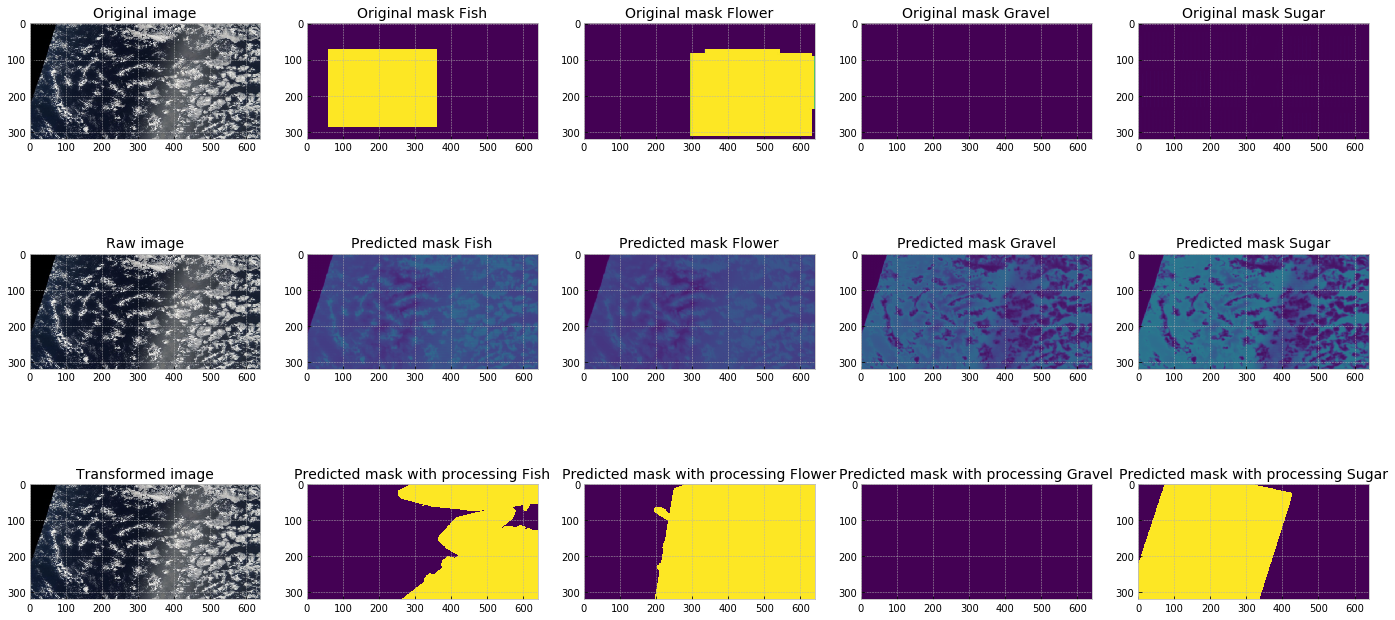

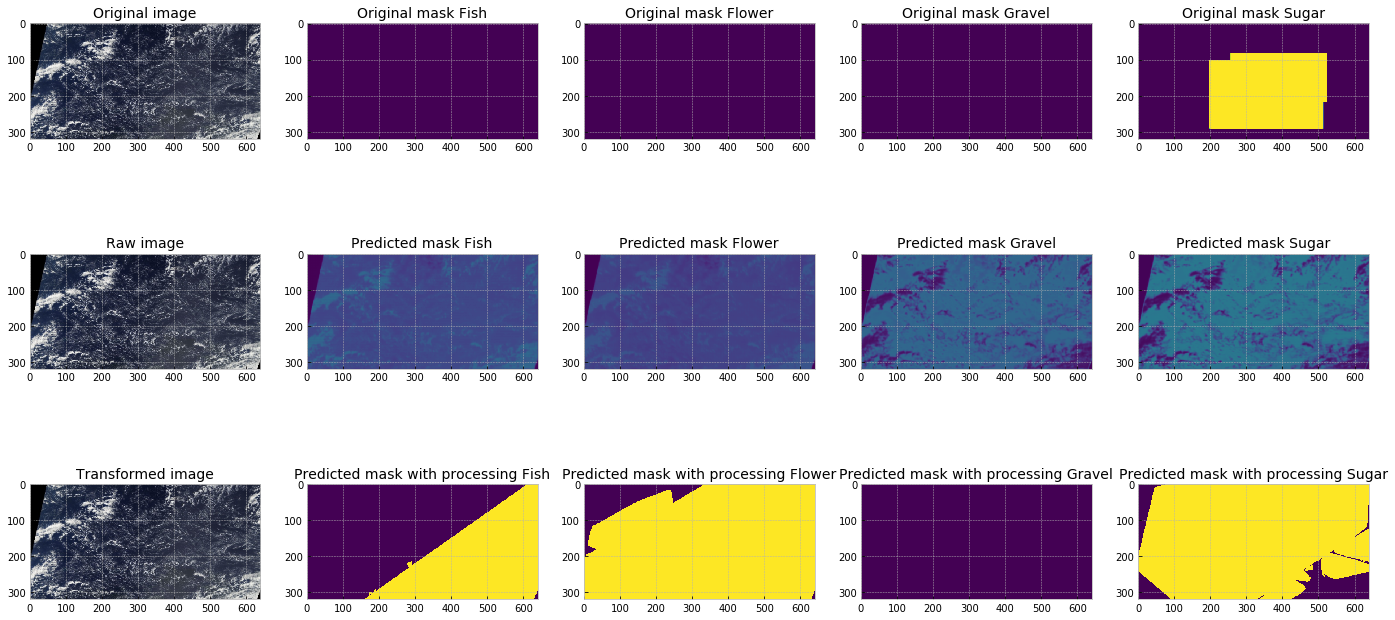

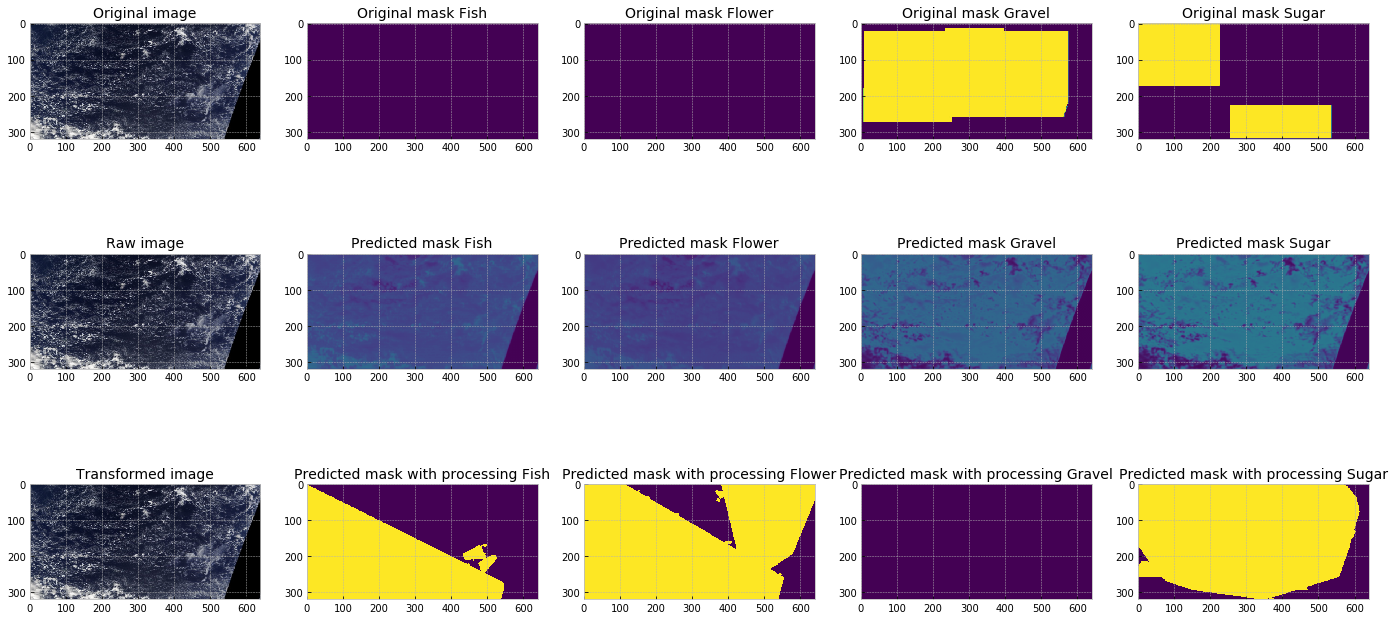

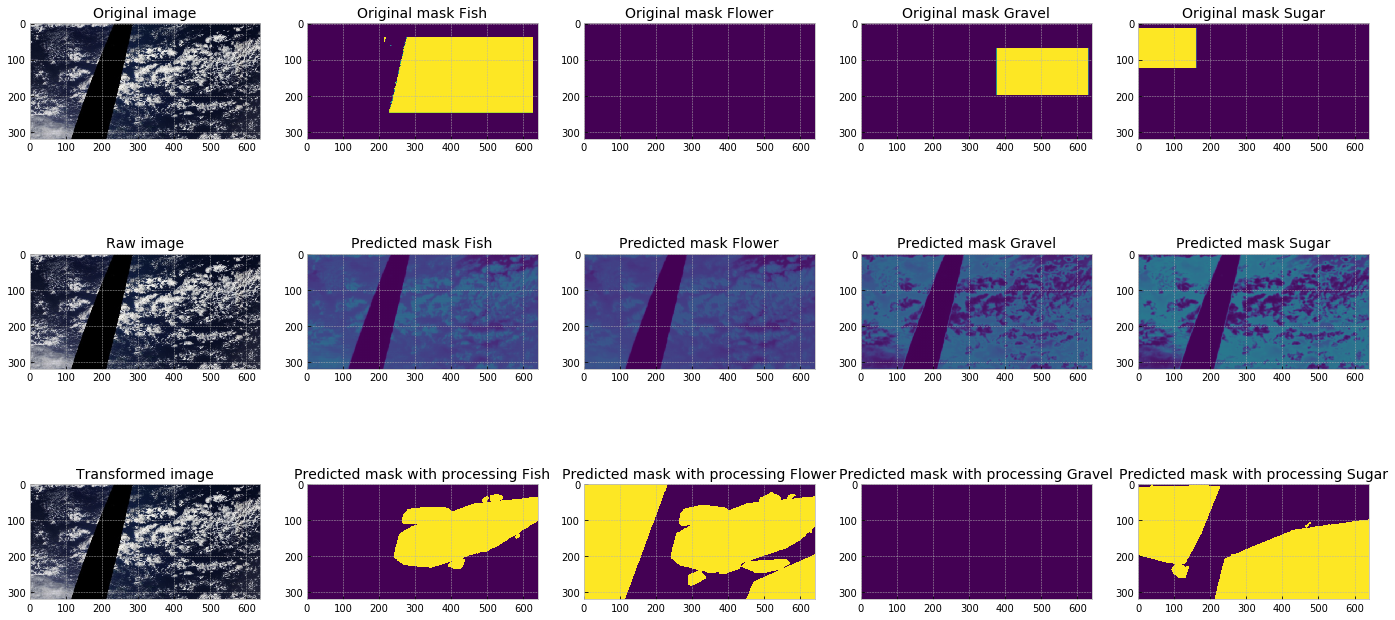

In [6]:
def post_process_minsize(mask, min_size):
  """
  Post processing of each predicted mask, components with lesser number of pixels
  than `min_size` are ignored
  """
  num_component, component = cv2.connectedComponents(mask.astype(numpy.uint8))
  predictions, num = numpy.zeros(mask.shape), 0
  for c in range(1, num_component):
    p = (component == c)
    if p.sum() > min_size:
      predictions[p] = 1
      num += 1
  return predictions


def threshold_mask(probability, threshold, min_size, psize):
  """
  This is slightly different from other kernels as we draw convex hull here itself.
  Post processing of each predicted mask, components with lesser number of pixels
  than `min_size` are ignored
  """
  mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
  mask = draw_convex_hull(mask.astype(numpy.uint8))
  num_component, component = cv2.connectedComponents(mask.astype(numpy.uint8))
  predictions = numpy.zeros(psize, numpy.float32)
  num = 0
  for c in range(1, num_component):
    p = component == c
    if p.sum() > min_size:
      predictions[p] = 1
      num += 1
  return predictions, num

def threshold_grid_search(model, valid_loader, max_samples=threshold_samples):
  ''' Grid Search for best Threshold '''

  valid_masks = []
  count = 0
  tr = min(valid_loader.dataset.__len__(), max_samples)
  probabilities = numpy.zeros((tr,
                               *CloudSegmentationDataset.image_size_T),
                              dtype=numpy.float32)
  for data, targets in tqdm(valid_loader):
    data = data.to(global_torch_device(),dtype=torch.float)
    predictions, *_ = model(data)
    predictions = torch.sigmoid(predictions)
    predictions = predictions.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    for p in range(data.shape[0]):
      pred, target = predictions[p], targets[p]
      for mask_ in target:
        valid_masks.append(mask_)
      for probability in pred:
        probabilities[count, :, :] = probability
        count += 1
      if count >= tr - 1:
        break
    if count >= tr - 1:
      break

  class_params = {}

  for class_id in CloudSegmentationDataset.categories.keys():
    print(CloudSegmentationDataset.categories[class_id])
    attempts = []
    for t in range(0, 100, 5):
      t /= 100
      print(t)
      for ms in MIN_SIZES:
        print(ms)
        masks, d = [], []
        for i in range(class_id, len(probabilities), 4):
          probability_ = probabilities[i]
          predict, num_predict = threshold_mask(probability_, t, ms,CloudSegmentationDataset.image_size_T)
          masks.append(predict)
        for i, j in zip(masks, valid_masks[class_id::4]):
          if (i.sum() == 0) & (j.sum() == 0):
            d.append(1)
          else:
            d.append(bool_dice(i, j))
        attempts.append((t, ms, numpy.mean(d)))

    attempts_df = pandas.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    class_params[class_id] = (best_threshold, best_size)

  return class_params


class_parameters = threshold_grid_search(model, valid_loader)

for _, (data, target) in zip(range(4),valid_loader):
    data = data.to(global_torch_device(),dtype=torch.float)
    output, *_ = model(data)
    output = torch.sigmoid(output)
    output= output[0].cpu().detach().numpy()
    image_vis = data[0].cpu().detach().numpy()
    mask = target[0].cpu().detach().numpy()

    mask = chw_to_hwc(mask)
    output = chw_to_hwc(output)
    image_vis = float_chw_to_hwc_uint(image_vis)

    pr_mask = numpy.zeros(CloudSegmentationDataset.response_shape)
    for j in range(len(CloudSegmentationDataset.categories)):
      probability_ = output[:, :, j]
      thr, min_size = class_parameters[j][0], class_parameters[j][1]
      pr_mask[:, :, j], _ = threshold_mask(probability_, thr, min_size, CloudSegmentationDataset.image_size_T)
    CloudSegmentationDataset.visualise_prediction(image_vis,
                                                  pr_mask,
                                                  original_image=image_vis,
                                                  original_mask=mask,
                                                  raw_image=image_vis,
                                                  raw_mask=output)

# Submission

In [7]:
def prepare_submission(model, class_params, test_loader, submission_file_path = 'submission.csv'):
  #encoded_pixels = []
  submission_i = 0
  number_of_pixels_saved = 0
  df:pandas.DataFrame = test_loader.dataset.data_frame
  a = df['Image_Label']

  with open(submission_file_path, mode='w') as f:
    f.write("Image_Label,EncodedPixels\n")
    for data, black_mask in tqdm(test_loader):
      data = data.to(global_torch_device(),dtype=torch.float)
      output, *_ = model(data)
      del data
      output = torch.sigmoid(output)
      output = output.cpu().detach().numpy()
      black_masks = black_mask.cpu().detach().numpy()
      for instance_i,black_mask in zip(output,black_masks):
        for probability in instance_i:
          thr, min_size = class_params[submission_i % 4][0], class_params[submission_i % 4][1]
          black_mask = resize_image_cv(black_mask, final_mask_size_T)
          probability = resize_image_cv(probability, final_mask_size_T)
          predict, num_predict = threshold_mask(probability, thr, min_size, final_mask_size_T)
          if num_predict == 0:
            rle=''
            #encoded_pixels.append('')
          else:
            number_of_pixels_saved += numpy.sum(predict)
            predict_masked2 = numpy.multiply(predict, black_mask)
            number_of_pixels_saved -= numpy.sum(predict_masked2)
            rle = mask_to_run_length(predict_masked2)
            #encoded_pixels.append(rle)

          f.write(f"{a[submission_i]},{rle}\n")
          submission_i += 1

    #df['EncodedPixels'] = encoded_pixels
    #df.to_csv(submission_file_path, columns=['Image_Label', 'EncodedPixels'], index=False)

  print(f"Number of pixel saved {number_of_pixels_saved}")

test_loader = DataLoader(CloudSegmentationDataset(base_dataset_path,
                                                    image_path,
                                                    subset='test'),
                           batch_size=batch_size,
                           shuffle=False,
                           num_workers=num_workers)

prepare_submission(model,
                 class_parameters,
                 test_loader
                 )

100%|██████████| 463/463 [06:03<00:00,  1.62it/s]

Number of pixel saved 933698.0
